In [1]:
import feedparser

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer

In [2]:
def tok(txt,stop):
    tokenizer = RegexpTokenizer(r'\w+')
    #tokens = tokenizer.tokenize(txt)

    #text =  nltk.word_tokenize(txt)
    
    return([i for i in txt.lower().split() if i not in stop])


def frq(words,anzahl):
    fdist = FreqDist(words)
    return(fdist.most_common(anzahl))
    

In [3]:
def get_year(stamp):
    return(str(stamp.year))

def get_month(stamp):
    return(str(stamp.month))

In [4]:
agw_path = '../data/full-antworten-rss.xml'

test_file = open(agw_path,'r')



In [5]:
feeds = feedparser.parse(agw_path)

In [6]:
nr_Answers = len(feeds.entries)

In [7]:
Politiker_list = []
Term_list = []
label_list = []
scheme_list = []
summary_list = []
published_list = []
link_list = []

In [8]:
for f in feeds.entries:
    title = [f.title]
    term = f.tags[0].term
    label = f.tags[0].label
    scheme = f.tags[0].scheme
    summary = f.summary
    published = f.published
    link = f.link
    Politiker_list.append(title)
    Term_list.append(term)
    label_list.append(label)
    scheme_list.append(scheme)
    summary_list.append(summary)
    published_list.append(published)
    link_list.append(link)

In [9]:
df_antwort = pd.DataFrame({'Politiker': Politiker_list,
                             'Antwort': summary_list,
                             'Datum': published_list,
                             'Term': Term_list,
                             'scheme': scheme_list,
                             'label': label_list,
                             'label': link_list,
                            })

In [11]:
df_antwort.to_csv('../data/full-antworten-rss.csv')
df_antwort['Datum'] = pd.to_datetime(df_antwort.Datum)
#df_antwort = df_antwort.set_index(df_antwort.Datum)
#df_antwort.groupby(pd.TimeGrouper("Y"))


In [16]:
df_antwort['Jahr'] = df_antwort.Datum.apply(get_year)
df_antwort['Monat'] = df_antwort.Datum.apply(get_month)

In [17]:
df_antwort['period'] = df_antwort['Jahr'] + '-'+ df_antwort['Monat'] 
#df_antwort['Jahr']
#df_antwort.loc[df_antwort['Jahr'] == '2013']


In [18]:
df_antwort['Politiker'], df_antwort['Partei'] = zip(*df_antwort['Politiker'].apply(lambda x: str(x).split('(', 1)))
df_antwort['Helper'] = 1

In [19]:
df_antwort['Politiker'] = df_antwort['Politiker'].map(lambda x: x.strip("['"))
df_antwort['Partei'] = df_antwort['Partei'].map(lambda x: x.strip("']"))
df_antwort['Partei'] = df_antwort['Partei'].map(lambda x: x.strip(")"))

In [20]:
df_antwort.head()

,Antwort,Datum,Politiker,Term,label,scheme,Jahr,Monat,period,Partei,Helper
0,"Sehr geehrter Herr Hausler,\n\nin Deutschland ...",2016-11-15 23:00:00,Rita Hagl-Kehl,Finanzen,http://www.abgeordnetenwatch.de/rita_hagl_kehl...,None,2016,11,2016-11,SPD,1
1,"Sehr geehrter Herr Schmidt,\n\nein Blick zurüc...",2016-01-27 23:00:00,Stefan Zierke,Arbeit,http://www.abgeordnetenwatch.de/stefan_zierke-...,None,2016,1,2016-1,SPD,1
2,"Sehr geehrter Herr Tillmann,\n\npositive Effek...",2014-08-14 23:00:00,Helga Kühn-Mengel,Finanzen,http://www.abgeordnetenwatch.de/helga_kuehn_me...,None,2014,8,2014-8,SPD,1
3,"Sehr geehrte Frau Kühns,\n\nim Folgenden möcht...",2014-08-14 23:00:00,Helga Kühn-Mengel,Demokratie und Bürgerrechte,http://www.abgeordnetenwatch.de/helga_kuehn_me...,None,2014,8,2014-8,SPD,1
4,"Sehr geehrter Herr Rodenberg,\n\ndie Debatte i...",2014-05-12 23:00:00,Oliver Grundmann,Arbeit,http://www.abgeordnetenwatch.de/oliver_grundma...,None,2014,5,2014-5,CDU,1


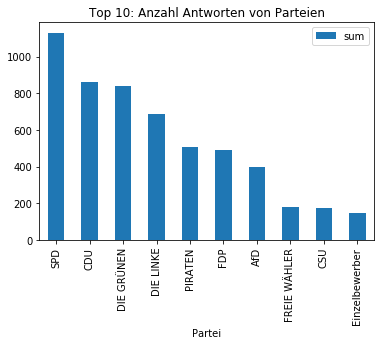

In [21]:
df_antwort.groupby(['Partei']).Helper.agg(['sum']).sort_values(by='sum', ascending=False).head(10).plot(kind='bar',  title='Top 10: Anzahl Antworten von Parteien')
plt.show()

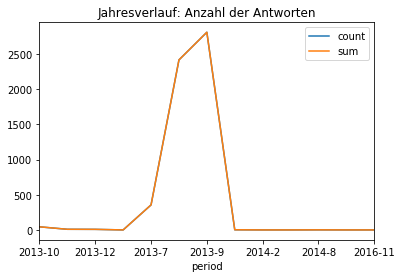

In [22]:
df_gb_period = df_antwort.groupby(['period']).Helper.agg(['count','sum']).sort_values(by='sum', ascending=False)
df_gb_period.head(15).sort_index(ascending=True)
df_gb_period.sort_index(ascending=True).plot(kind='line',  title='Jahresverlauf: Anzahl der Antworten')
plt.show()

In [23]:
pd.pivot_table(df_antwort,index=['Partei','Politiker'], values=['Helper'],aggfunc=np.sum).head(5)


Helper
Partei Politiker               
AfD    Alan Imamura           3
       Andrea Konorza         3
       Andreas Dahl           4
       Anna Schupeck          2
       Arndt Klapproth        1

In [24]:
stopp = set(stopwords.words('german'))
stopp.update(['dass',
              'dafür',
              '-',
              '–',
              'werden',
              'werden.',
              'werden,',
              'statt',
              'mehr',
              'deshalb',
              'ebenso',
              'bisher',
              'z.b.',
              'herr',
              'frau',
              'geehrter',
              'geehrte',
              'grüße',
              'grüßen',
              'freundliche',
              'freundlichen',
              'vielen',
              'dank',
              'müssen',
              'frage',
              'immer',
              'schon',
              'viele'
             ])
    

df_antwort['analyse'] = df_antwort.Antwort.apply(tok,stop=stopp)

In [25]:
df_antwort['most_common'] = df_antwort.analyse.apply(frq,anzahl=2)
df_antwort

,Antwort,Datum,Politiker,Term,label,scheme,Jahr,Monat,period,Partei,Helper,analyse,most_common
0,"Sehr geehrter Herr Hausler,\n\nin Deutschland ...",2016-11-15 23:00:00,Rita Hagl-Kehl,Finanzen,http://www.abgeordnetenwatch.de/rita_hagl_kehl...,None,2016,11,2016-11,SPD,1,"[hausler,, deutschland, wurde, eurokrise, verg...","[(deutschland, 2), (gut, 2)]"
1,"Sehr geehrter Herr Schmidt,\n\nein Blick zurüc...",2016-01-27 23:00:00,Stefan Zierke,Arbeit,http://www.abgeordnetenwatch.de/stefan_zierke-...,None,2016,1,2016-1,SPD,1,"[schmidt,, blick, zurück:, fünf, millionen, be...","[(millionen, 3), (2010, 3)]"
2,"Sehr geehrter Herr Tillmann,\n\npositive Effek...",2014-08-14 23:00:00,Helga Kühn-Mengel,Finanzen,http://www.abgeordnetenwatch.de/helga_kuehn_me...,None,2014,8,2014-8,SPD,1,"[tillmann,, positive, effekte, hinblick, bunde...","[(bund, 3), (zudem, 2)]"
3,"Sehr geehrte Frau Kühns,\n\nim Folgenden möcht...",2014-08-14 23:00:00,Helga Kühn-Mengel,Demokratie und Bürgerrechte,http://www.abgeordnetenwatch.de/helga_kuehn_me...,None,2014,8,2014-8,SPD,1,"[kühns,, folgenden, möchte, beantworten, bedau...","[(zukunft, 3), (unterzeichnerinnen, 2)]"
4,"Sehr geehrter Herr Rodenberg,\n\ndie Debatte i...",2014-05-12 23:00:00,Oliver Grundmann,Arbeit,http://www.abgeordnetenwatch.de/oliver_grundma...,None,2014,5,2014-5,CDU,1,"[rodenberg,, debatte, plenum, bundestages, die...","[(abgeordneten, 4), (debatte, 2)]"
5,"Sehr geehrter Herr Müller,\n\nfür die Schilder...",2014-02-12 23:00:00,Mark Hauptmann,Demokratie und Bürgerrechte,http://www.abgeordnetenwatch.de/mark_hauptmann...,None,2014,2,2014-2,CDU,1,"[müller,, schilderung, anliegens, internetseit...","[(möchte, 3), (bebauungsplans, 2)]"
6,"Sehr geehrter Herr Odeon,\n\nhaben Sie besten ...",2014-01-19 23:00:00,Wolfgang Stefinger,Internationales,http://www.abgeordnetenwatch.de/wolfgang_stefi...,None,2014,1,2014-1,CSU,1,"[odeon,, besten, anfrage,, abgeordnetenwatch, ...","[(deutschland, 7), (beziehungen, 5)]"
7,"Sehr geehrter Herr Heldt,\n\nzunächst einmal v...",2014-01-12 23:00:00,Matthias Ilgen,Frauen,http://www.abgeordnetenwatch.de/matthias_ilgen...,None,2014,1,2014-1,SPD,1,"[heldt,, zunächst, frage., leider, technischen...","[(gar, 3), (zunächst, 2)]"
8,"Sehr geehrte Frau Kaune,\n\nzunächst einmal mö...",2014-01-12 23:00:00,Bernd Westphal,Umwelt,http://www.abgeordnetenwatch.de/bernd_westphal...,None,2014,1,2014-1,SPD,1,"[kaune,, zunächst, möchte, entschuldigen,, ers...","[(umwelt, 4), (bezug, 3)]"
9,Sehr geehrter Herr Zweifel.\n\nIch bin in dies...,2013-12-19 23:00:00,Hans-Christian Ströbele,Senioren,http://www.abgeordnetenwatch.de/hans_christian...,None,2013,12,2013-12,DIE GRÜNEN,1,"[zweifel., bereich, experte,, wohl, so,, beamt...","[(wohl, 4), (beamte, 4)]"


In [26]:
most = [i for sub in df_antwort.most_common for i in sub]
df = pd.DataFrame({'MeisteWoerter':most })
df['MeistesWort'], df['Anzahl'] = zip(*df['MeisteWoerter'].apply(lambda x: str(x).split(', ', 1)))

df['Anzahl'] = df['Anzahl'].map(lambda x: x.strip(')'))
df['MeistesWort'] = df['MeistesWort'].map(lambda x: x.strip('('))
df['MeistesWort'] = df['MeistesWort'].map(lambda x: x.strip("'"))

del df['MeisteWoerter']

In [27]:
df.sort_values('Anzahl')
df.groupby(['MeistesWort']).size().sort_values(ascending=False)


MeistesWort
deutschland            197
menschen               168
euro                   114
spd                     89
linke                   80
thema                   75
bürger                  69
partei                  60
fragen                  55
rente                   49
hallo                   48
kinder                  46
fdp                     45
gerne                   45
deutschen               42
politik                 41
bereits                 40
daher                   40
bildung                 39
ja                      39
lieber                  39
halte                   39
bundesregierung         39
unternehmen             39
energiewende            38
europäischen            38
arbeit                  38
grünen                  38
frauen                  37
unserer                 36
                      ... 
minderjährige            1
militärische             1
militäreinsatz           1
militäraktionen          1
mietspiegel              1
moabit          

In [28]:
df_gb_text = df_antwort.groupby('period')['Antwort'].apply(lambda x: ' '.join(x))
df_gb_text = pd.DataFrame(df_gb_text)

df_gb_text2 = df_antwort.groupby(['period','Partei'])['Antwort'].apply(lambda x: ' '.join(x))
df_gb_text2 =pd.DataFrame(df_gb_text2)
df_gb_text2

Antwort
period  Partei                                                                          
2013-10 CDU                            Sehr geehrte Frau Walkenhorst,\n\nwie bereits ...
        CSU                            Sehr geehrter Herr Killer,\n\nhaben Sie besten...
        DIE GRÜNEN                     Sehr geehrter Herr Maier,\n\nvielen Dank für I...
        DIE LINKE                      Sehr geehrter Herr Altmann,\n\ndanke für Ihre ...
        FDP                            Sehr geehrter Herr Schultz,\n\nvielen Dank für...
        SPD                            Sehr geehrter Herr Hall,\n\nich danke Ihnen fü...
2013-11 CDU                            Sehr geehrter Herr Goetz,\n\nvielen Dank für I...
        DIE LINKE                      Sehr geehrte Frau Kinder,\n\nin der Drogenpoli...
        SPD                            Sehr geehrte Frau Block,\n\nvielen Dank für Ih...
2013-12 DIE GRÜNEN                     Sehr geehrter Herr Zweifel.\n\nIch bin in dies...
        SPD                            Sehr geehrte Frau Eck,\n\nvielen Dank für Ihre...
2013-6  SPD                            Sehr geehrter Herr Bremenkamp,\n\ndie Rettung ...
2013-7  AfD                            Sehr geehrter Herr Zenker,\n\nVielen Dank für ...
        Bündnis 21/RRP                 *Hallo Frau Turner,*\n\nDie steuerliche Gleich...
        CDU                            Sehr geehrter Herr Dr. Grobe,\n\nvielen Dank f...
        CSU                            Sehr geehrter Herr Schmelcher,\n\n vielen Dank...
        DIE GRÜNEN                     Sehr geehrter Herr Reth,\n\nvielen Dank für Ih...
        DIE LINKE                      Sehr geehrter Herr Freder,\n\nich kann Ihrer B...
        Die PARTEI                     Sehr geehrter Herr Pingel,\n\nVielen Dank für ...
        Einzelbewerber                 Sehr geehrter Herr Rohrßen,\n\nvielen Dank für...
        FDP                            Sehr geehrter Herr Pfeifer,\n\nvielen dank für...
        FREIE WÄHLER                   Sehr geehrter Herr Stegmann,\n\nnein, trotz Nu...
        MLPD                           Guten Tag Herr Wille!\n \nDanke für ihre Frage...
        PIRATEN                        Hallo Herr Dorste,\n\nich bin ein großer Befür...
        SPD                            Sehr geehrte Frau Schweitzer,\n\ndanke für Ihr...
        ÖDP                            Sehr geehrte Frau Rauschenberg,\n\nvielen Dank...
2013-8  AfD                            Sehr geehrter Herr Grünholz,\n\nherzlichen Dan...
        Bergpartei                     hey, reinhard!\n\nich verstehe deine geostrate...
        Bündnis 21/RRP                 Sehr geehrter Herr Rudat,\n\nvielen Dank für I...
        CDU                            Sehr geehrter Herr Radunski,\n\ndie CDU und ic...
...                                                                                  ...
2013-9  Bergpartei                     hey, andreas\n\nfür mich stellt sich die frage...
        BüSo                           Sehr geehrter Herr Mayer,\n\nDie Frage der Zuw...
        Bündnis 21/RRP                 Vielen Dank Frau Waldorf für ihre Frage\n\nDa ...
        CDU                            Sehr geehrter Herr Timm,\n\ndie EU besteht aus...
        CSU                            Sehr geehrte Frau Tietze,\n\nvielen Dank für I...
        DIE GRÜNEN                     Lieber Herr Bärsch,\n\ndie Idee des bedingungs...
        DIE LINKE                      Sehr geehrter Herr Mayer-Geesen,\n\ndie von Ih...
        DIE VIOLETTEN                  Liebe Frau Schäfer,\n\nvielen Dank für Ihre Fr...
        DKP                            Sehr geehrter Herr Mayer,\n\nbitte entschuldig...
        Deutsche Mitte                 Sehr geehrter Herr Wehner,\n\nhier sind zu mei...
        Die PARTEI                     Sehr geehrter Herr Richter,\n\nvielen Dank für...
        Einzelbewerber                 Sehr geehrter Herr Graw,\n\nDie kurze Antwort ...
        FAMILIEN-PARTEI                Sehr geehrter Interessent ,\n\nherzli

In [29]:
df_gb_text['analyse'] = df_gb_text.Antwort.apply(tok,stop=stopp)
df_gb_text['most_common'] = df_gb_text.analyse.apply(frq,anzahl=5)

In [30]:
#Meist genutzte Wörter der Parteien pro Monat

df_gb_text2['analyse'] = df_gb_text2.Antwort.apply(tok,stop=stopp)
df_gb_text2['most_common'] = df_gb_text2.analyse.apply(frq,anzahl=3)
df_gb_text2

Antwort  \
period  Partei                                                                             
2013-10 CDU                            Sehr geehrte Frau Walkenhorst,\n\nwie bereits ...   
        CSU                            Sehr geehrter Herr Killer,\n\nhaben Sie besten...   
        DIE GRÜNEN                     Sehr geehrter Herr Maier,\n\nvielen Dank für I...   
        DIE LINKE                      Sehr geehrter Herr Altmann,\n\ndanke für Ihre ...   
        FDP                            Sehr geehrter Herr Schultz,\n\nvielen Dank für...   
        SPD                            Sehr geehrter Herr Hall,\n\nich danke Ihnen fü...   
2013-11 CDU                            Sehr geehrter Herr Goetz,\n\nvielen Dank für I...   
        DIE LINKE                      Sehr geehrte Frau Kinder,\n\nin der Drogenpoli...   
        SPD                            Sehr geehrte Frau Block,\n\nvielen Dank für Ih...   
2013-12 DIE GRÜNEN                     Sehr geehrter Herr Zweifel.\n\nIch bin in dies...   
        SPD                            Sehr geehrte Frau Eck,\n\nvielen Dank für Ihre...   
2013-6  SPD                            Sehr geehrter Herr Bremenkamp,\n\ndie Rettung ...   
2013-7  AfD                            Sehr geehrter Herr Zenker,\n\nVielen Dank für ...   
        Bündnis 21/RRP                 *Hallo Frau Turner,*\n\nDie steuerliche Gleich...   
        CDU                            Sehr geehrter Herr Dr. Grobe,\n\nvielen Dank f...   
        CSU                            Sehr geehrter Herr Schmelcher,\n\n vielen Dank...   
        DIE GRÜNEN                     Sehr geehrter Herr Reth,\n\nvielen Dank für Ih...   
        DIE LINKE                      Sehr geehrter Herr Freder,\n\nich kann Ihrer B...   
        Die PARTEI                     Sehr geehrter Herr Pingel,\n\nVielen Dank für ...   
        Einzelbewerber                 Sehr geehrter Herr Rohrßen,\n\nvielen Dank für...   
        FDP                            Sehr geehrter Herr Pfeifer,\n\nvielen dank für...   
        FREIE WÄHLER                   Sehr geehrter Herr Stegmann,\n\nnein, trotz Nu...   
        MLPD                           Guten Tag Herr Wille!\n \nDanke für ihre Frage...   
        PIRATEN                        Hallo Herr Dorste,\n\nich bin ein großer Befür...   
        SPD                            Sehr geehrte Frau Schweitzer,\n\ndanke für Ihr...   
        ÖDP                            Sehr geehrte Frau Rauschenberg,\n\nvielen Dank...   
2013-8  AfD                            Sehr geehrter Herr Grünholz,\n\nherzlichen Dan...   
        Bergpartei                     hey, reinhard!\n\nich verstehe deine geostrate...   
        Bündnis 21/RRP                 Sehr geehrter Herr Rudat,\n\nvielen Dank für I...   
        CDU                            Sehr geehrter Herr Radunski,\n\ndie CDU und ic...   
...                                                                                  ...   
2013-9  Bergpartei                     hey, andreas\n\nfür mich stellt sich die frage...   
        BüSo                           Sehr geehrter Herr Mayer,\n\nDie Frage der Zuw...   
        Bündnis 21/RRP                 Vielen Dank Frau Waldorf für ihre Frage\n\nDa ...   
        CDU                            Sehr geehrter Herr Timm,\n\ndie EU besteht aus...   
        CSU                            Sehr geehrte Frau Tietze,\n\nvielen Dank für I...   
        DIE GRÜNEN                     Lieber Herr Bärsch,\n\ndie Idee des bedingungs...   
        DIE LINKE                      Sehr geehrter Herr Mayer-Geesen,\n\ndie von Ih...   
        DIE VIOLETTEN                  Liebe Frau Schäfer,\n\nvielen Dank für Ihre Fr...   
        DKP                            Sehr geehrter Herr Mayer,\n\nbitte entschuldig...   
        Deutsche Mitte                 Sehr geehrter Herr Wehner,\n\nhier sind zu mei...   
        Die PARTEI                     Sehr geehrter Herr Richter,\n\nvielen Dank für...   
        Einzelbewerber           

In [31]:
#export = df_antwort.to_csv('', sep=';')